In [1]:
from tensorflow.keras.utils import plot_model
import visualkeras
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import *
import matplotlib.pyplot as plt
import math
plt.rcParams["figure.figsize"] = (20,10)

def m2tex(model,modelName):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: {} \\\\ \hline".format(modelName)
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] += " \hline"
    stringlist[-3] += " \\\\"
    stringlist[-2] += " \\\\"
    stringlist[-1] += " \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{{Model summary for {}.}}".format(modelName), "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)


## Import Data


In [2]:
X_train = pd.read_csv("../Baseline/data2UEjoint/X_train_joint.csv", index_col=0)
y_train = pd.read_csv("../Baseline/data2UEjoint/y_train_joint.csv", index_col=0)

X_test = pd.read_csv("../Baseline/data2UEjoint/X_valid_joint.csv", index_col=0)
y_test = pd.read_csv("../Baseline/data2UEjoint/y_valid_joint.csv", index_col=0)


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(708, 1280)
(708, 3840)
(472, 1280)
(472, 3840)


In [4]:
X_train = (X_train.to_numpy())
X_test = (X_test.to_numpy())
y_train = (y_train.to_numpy())
y_test = (y_test.to_numpy())

In [5]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_esc = scaler.transform(X_train)
X_test_esc = scaler.transform(X_test)

## Create a sampling layer


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the encoder


In [9]:
latent_dim = 100 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
Leaky_ReLu = keras.layers.LeakyReLU(alpha=0.01)

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(309, activation=Leaky_ReLu)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 309)          395829      ['input_2[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 100)          31000       ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 100)          31000       ['dense[0][0]']                  
                                                                                            

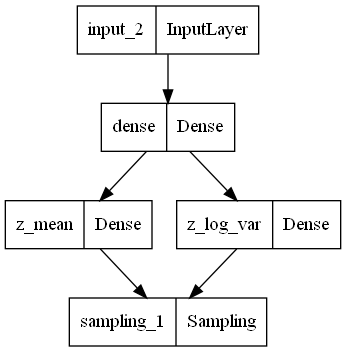

In [10]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

In [11]:
m2tex(encoder, 'encoder')

\begin{table}[] 
\begin{tabular}{lll} 
Model: encoder \\ \hline 
 Layer (type)          Output S& hape   Param   Connected to &            \\ \hline \hline 
===============================& ============================& ===========\\ \hline 
                       ]       &                             &            \\ \hline 
 dense (Dense)         (None, 3& 09)    395829  ['input\_2[0][& 0]']       \\ \hline 
 z\_mean (Dense)        (None, 1& 00)    31000   ['dense[0][0]& ']         \\ \hline 
 z\_log\_var (Dense)     (None, 1& 00)    31000   ['dense[0][0]& ']         \\ \hline 
 sampling\_1 (Sampling)  (None, & 100)   0       ['z\_mean[0][0& ]',        \\ \hline 
                               &                             &            \\ \hline \hline 
Total params: 457,829 \\ 
Trainable params: 457,829 \\ 
Non-trainable params: 0 \\ \hline 
\end{tabular} 
\caption{Model summary for encoder.} 
\label{tab:model-summary} 
\end{table}


## Build the decoder


In [25]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(300,  activation=Leaky_ReLu)(latent_inputs)
x = layers.Dense(600,  activation=Leaky_ReLu)(latent_inputs)

decoder_outputs = layers.Dense(input_dim * 3, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 600)               60600     
                                                                 
 dense_5 (Dense)             (None, 3840)              2307840   
                                                                 
Total params: 2,368,440
Trainable params: 2,368,440
Non-trainable params: 0
_________________________________________________________________


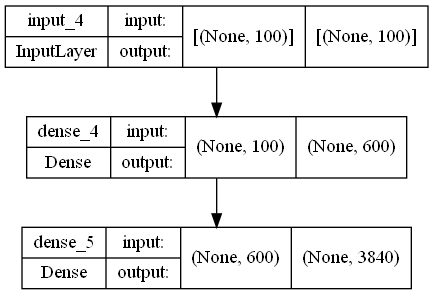

In [26]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

In [27]:
m2tex(decoder, 'decoder')

\begin{table}[] 
\begin{tabular}{lll} 
Model: decoder \\ \hline 
 Layer (type)                  & Output Shape                & Param \#    \\ \hline \hline 
 input\_4 (InputLayer)          & [(None, 100)]               & 0          \\ \hline 
 dense\_4 (Dense)               & (None, 600)                 & 60600      \\ \hline 
 dense\_5 (Dense)               & (None, 3840)                & 2307840    \\ \hline 
===============================& ============================& ===========\\ \hline \hline 
Total params: 2,368,440 \\ 
Trainable params: 2,368,440 \\ 
Non-trainable params: 0 \\ \hline 
\end{tabular} 
\caption{Model summary for decoder.} 
\label{tab:model-summary} 
\end{table}


## Define the VAE as a Model with a custom train_step


In [28]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, KL_hyperparam, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.KL_hyperparam = KL_hyperparam
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")  #MEAN? 
        self.reconstruction_loss_tracker = keras.metrics.Mean(    #MEAN? 
            name="MSE"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")   #MEAN? 
        
        self.total_loss_tracker_val = keras.metrics.Mean(name="total_loss_val")  #MEAN? 
        self.reconstruction_loss_tracker_val = keras.metrics.Mean(    #MEAN? 
            name="MSE_val"
        )
        self.kl_loss_tracker_val = keras.metrics.Mean(name="kl_loss_val")   #MEAN? 

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            
            self.total_loss_tracker_val,
            self.reconstruction_loss_tracker_val,
            self.kl_loss_tracker_val
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #kl_loss = tf.reduce_mean(kl_loss, axis=1)
            
            total_loss = reconstruction_loss + kl_loss * self.KL_hyperparam
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "MSE": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        x, y_true = data
        # Compute predictions
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        
        ## Losses
        reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss * self.KL_hyperparam

        # Updates the metrics tracking the loss
        self.total_loss_tracker_val.update_state(total_loss)
        
        self.reconstruction_loss_tracker_val.update_state(reconstruction_loss)
        
        self.kl_loss_tracker_val.update_state(kl_loss)
        
        return {
            "loss_val": self.total_loss_tracker_val.result(),
            "MSE_val": self.reconstruction_loss_tracker_val.result(),
            "kl_loss_val": self.kl_loss_tracker_val.result(),
        }



    def call(self, inputs):

        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
                


        return reconstruction
    


## Train the VAE

In [29]:
vae = VAE(encoder, decoder,1)

In [30]:
vae.compile(optimizer=keras.optimizers.Adam())

In [31]:
es = keras.callbacks.EarlyStopping(
    monitor="MSE",
    patience=4,
)

In [32]:
history = vae.fit(X_train_esc, y_train, validation_data=(X_test_esc, y_test), epochs=35, batch_size=15)#, callbacks=es)

Epoch 1/35
48/48 [==============================] - 1s 21ms/step - loss: 1.1170 - MSE: 0.0352 - kl_loss: 1.2834 - val_loss_val: 6.1242 - val_MSE_val: 0.0285 - val_kl_loss_val: 6.0876
Epoch 2/35
48/48 [==============================] - 1s 23ms/step - loss: 1.1156 - MSE: 0.0245 - kl_loss: 0.9835 - val_loss_val: 4.2392 - val_MSE_val: 0.0248 - val_kl_loss_val: 4.2063
Epoch 3/35
48/48 [==============================] - 1s 31ms/step - loss: 0.5532 - MSE: 0.0225 - kl_loss: 0.4630 - val_loss_val: 3.2453 - val_MSE_val: 0.0237 - val_kl_loss_val: 3.2180
Epoch 4/35
48/48 [==============================] - 2s 43ms/step - loss: 0.2573 - MSE: 0.0217 - kl_loss: 0.2118 - val_loss_val: 2.7465 - val_MSE_val: 0.0230 - val_kl_loss_val: 2.7198
Epoch 5/35
48/48 [==============================] - 2s 34ms/step - loss: 0.1420 - MSE: 0.0210 - kl_loss: 0.1118 - val_loss_val: 2.4655 - val_MSE_val: 0.0224 - val_kl_loss_val: 2.4391
Epoch 6/35
48/48 [==============================] - 2s 32ms/step - loss: 0.0881 - MSE

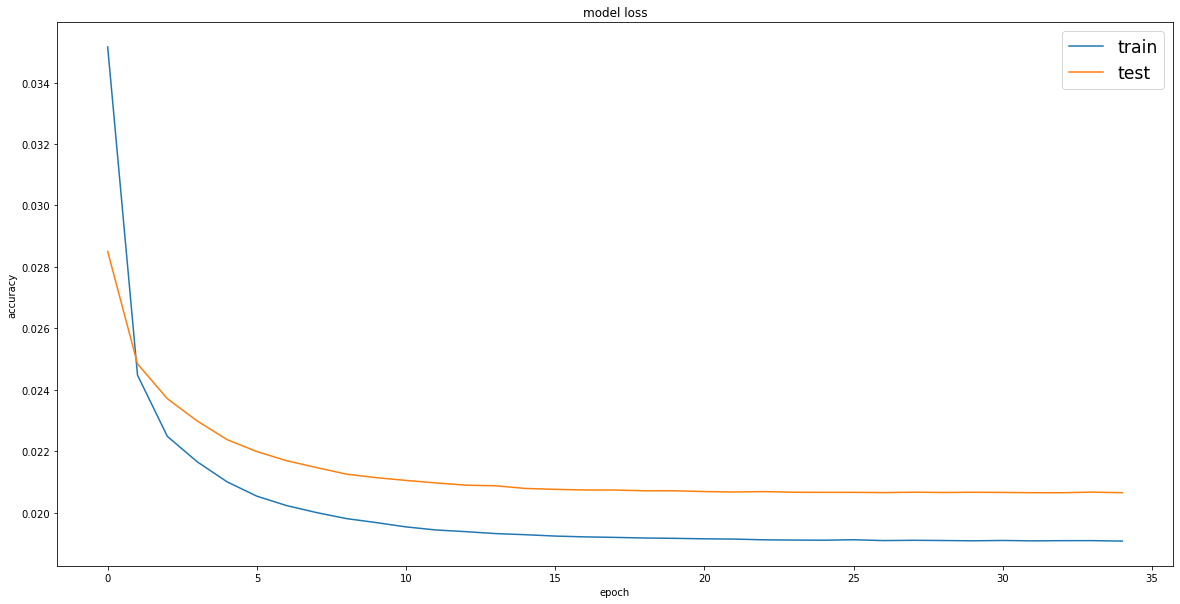

In [36]:
# summarize history for accuracy
plt.plot(history.history['MSE'])
#plt.plot(history.history['val_total_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['val_MSE_val'])

plt.legend(['train', 'test'], loc='upper right', fontsize ='xx-large')
plt.show()


In [43]:
samp_num = 1

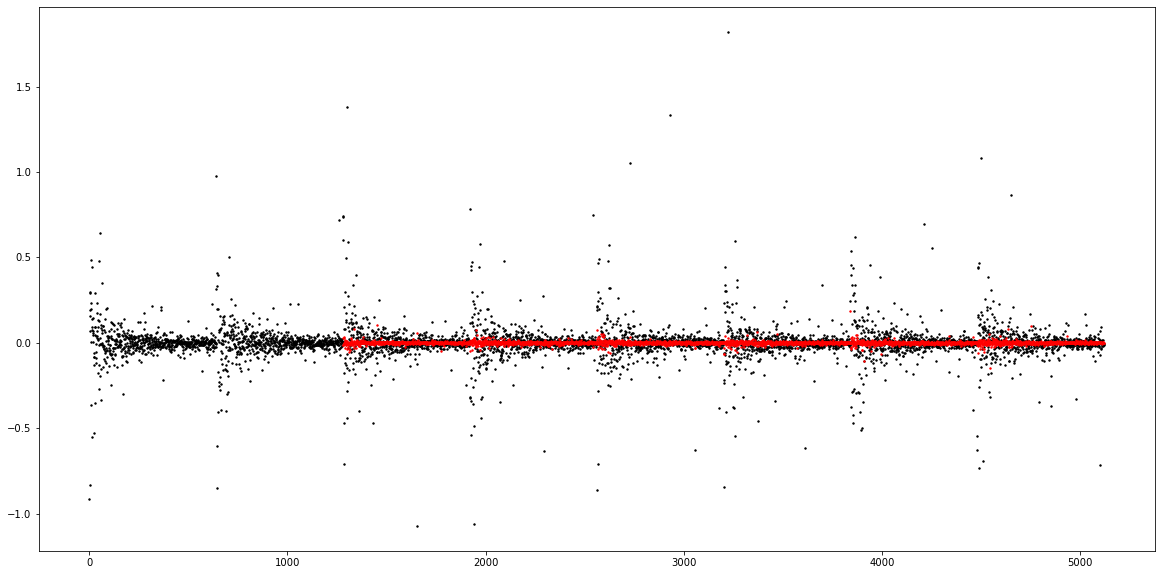

In [44]:
sample_1 = np.r_[ y_test[samp_num,], X_test[samp_num,]]
idx = np.arange(len(sample_1))
plt.scatter(np.arange(len(sample_1)), sample_1, s=2, c="black")
plt.scatter(idx[-len(vae.predict(X_test)[samp_num,]):], vae.predict(X_test)[samp_num,], color='red',  s=2)


In [45]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


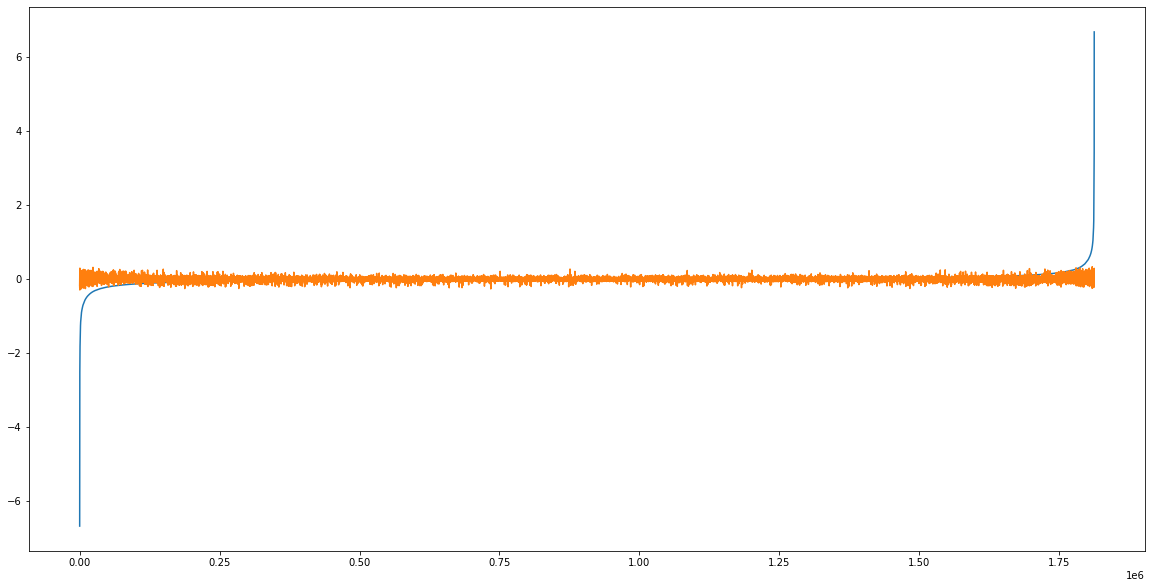

In [40]:
plt.plot(np.sort(y_test.flatten()))

plt.plot(vae.predict(X_test_esc).flatten()[np.argsort(y_test.flatten())])

In [227]:
def nrmse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    den = tf.math.reduce_sum(tf.square(y_test))/y_test.shape[1]
    
    return (num/den).numpy()

def mse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

def mae(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.abs(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

print('NRMSE', nrmse(vae.predict(X_test), y_test))
print('MAE', mae(vae.predict(X_test), y_test))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test)))
print('MSE', mse(vae.predict(X_test), y_test))


NRMSE 1.010073768846052
MAE 28.642736364962396
RMSE 3.128995234146258
MSE 9.79330188769235
